# Accelerometer signal classification: etalon classes

## Data preparation

In [1]:
import pickle
import re
import random
import sys
import time

from IPython.display import Markdown, display

from scipy.io import loadmat

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scipy import signal

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
df = pd \
    .read_csv('../data/data60.csv') \
    .set_index(['class', 'experiment', 'sample', 'frame']) \
    .unstack('frame')

df.columns.names = ['axis', 'frame']
df

axis                               x                                   \
frame                             0          1          2          3    
class   experiment sample                                               
cycling 1          0       -1.455675  -2.106897  -0.153229  -1.800440   
                   1       -7.776367  -8.236053  -6.282385  -7.086837   
                   2      -10.687716  -9.078813  -7.584831  -8.504205   
                   3       -6.550536  -5.937620  -6.052542 -12.641385   
                   4       -9.308656 -10.994174  -7.967903  -3.102885   
                   5       -8.695741 -11.990162 -10.113108 -10.113108   
                   6       -5.746084  -3.485958  -4.903325  -8.389282   
                   7      -10.687716  -9.423577  -9.806650  -9.576807   
                   8      -11.377246  -6.665457  -4.520253  -4.826711   
                   9      -10.496181  -9.959879  -8.657433  -7.125144   
                   10      -7.431602  -3.792415  -4.558560  -7.316680   
                   11      -9.730036  -9.193734  -7.623138  -9.538500   
                   12      -5.784391  -7.661445 -12.220005 -10.304644   
                   13      -8.044517  -4.405331  -4.175488  -7.163451   
                   14      -9.193734  -7.431602  -8.734048  -9.921572   
                   15      -4.941632  -8.389282  -5.094861 -10.457872   
                   16      -7.623138  -8.006210 -10.036493  -8.197746   
                   17      -7.125144  -6.090849 -10.228029  -9.959879   
                   18      -8.734048  -8.082825  -8.580819  -6.665457   
                   19      -6.971915  -6.780379  -7.086837 -11.300631   
                   20      -8.695741  -8.044517  -8.236053  -8.810662   
                   21      -9.040505  -4.405331  -4.711789  -8.006210   
                   22      -5.746084  -6.512228 -10.879252  -8.465897   
                   23      -7.967903  -6.818687  -8.542512 -10.457872   
                   24      -3.485958  -7.201758  -6.512228  -5.784391   
                   25      -9.959879 -10.113108  -8.044517  -7.469909   
                   26      -4.673482  -5.861006  -7.125144  -4.979939   
                   27     -10.649409  -8.197746  -7.546524  -8.504205   
                   28      -3.294421  -4.252102  -7.852982  -6.397307   
                   29      -9.768343  -8.887277  -7.086837  -8.121132   
...                              ...        ...        ...        ...   
walking 242        2484     1.723825   4.788404   2.643199  -3.715801   
                   2485     1.110910   3.064578   2.298433   2.068590   
                   2486    -2.796428   3.639187  -0.536301  -2.106897   
                   2487     4.596867   3.294421  -0.459687  -7.891289   
                   2488     2.145205   5.018247   1.915361   3.830723   
                   2489     2.528277   2.068590   1.800440  -0.881066   
                   2490    -0.727837   2.336741   4.481946  -0.076614   
                   2491    -2.681506  -2.681506  -1.800440   0.038307   
                   2492     2.451662   3.256114   1.647211  -0.459687   
                   2493    -3.141193  -1.762132   1.877054   2.528277   
                   2494    -4.826711  -1.264139   8.236053  -3.256114   
                   2495     2.106897   1.570596   1.379060   1.877054   
                   2496    -1.838747   2.298433   2.145205  -0.076614   
                   2497     0.727837  -2.643199   2.681506   1.877054   
                   2498    -2.260126   2.106897   2.566584  -0.459687   
                   2499    -3.524265   4.443638  -0.804452   5.363012   
                   2500     2.030283   1.723825  -1.340753   2.106897   
                   2501    -1.493982   1.110910  -2.681506  -1.187524   
                   2502    -5.784391   2.796428   2.681506  -3.945644   
                   2503     0.919373   2.145205   1.991976  -1.800440   
                   2504    -2.336741  -3.217807  -0.804452

In [3]:
df = df \
    .rename({'idle': 'still', 'standing': 'still', 'sitting': 'still'}) \
    .groupby(level=0) \
    .apply(lambda g: g \
       .reset_index() \
       .set_index('experiment', append=True) \
       .drop(columns=['class', 'sample']) \
    )


df.index.levels[1].name = 'sample'
df

c:\users\dkibe\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



axis                               x                                   \
frame                             0          1          2          3    
class   sample experiment                                               
cycling 0      1           -1.455675  -2.106897  -0.153229  -1.800440   
        1      1           -7.776367  -8.236053  -6.282385  -7.086837   
        2      1          -10.687716  -9.078813  -7.584831  -8.504205   
        3      1           -6.550536  -5.937620  -6.052542 -12.641385   
        4      1           -9.308656 -10.994174  -7.967903  -3.102885   
        5      1           -8.695741 -11.990162 -10.113108 -10.113108   
        6      1           -5.746084  -3.485958  -4.903325  -8.389282   
        7      1          -10.687716  -9.423577  -9.806650  -9.576807   
        8      1          -11.377246  -6.665457  -4.520253  -4.826711   
        9      1          -10.496181  -9.959879  -8.657433  -7.125144   
        10     1           -7.431602  -3.792415  -4.558560  -7.316680   
        11     1           -9.730036  -9.193734  -7.623138  -9.538500   
        12     1           -5.784391  -7.661445 -12.220005 -10.304644   
        13     1           -8.044517  -4.405331  -4.175488  -7.163451   
        14     1           -9.193734  -7.431602  -8.734048  -9.921572   
        15     1           -4.941632  -8.389282  -5.094861 -10.457872   
        16     1           -7.623138  -8.006210 -10.036493  -8.197746   
        17     1           -7.125144  -6.090849 -10.228029  -9.959879   
        18     1           -8.734048  -8.082825  -8.580819  -6.665457   
        19     1           -6.971915  -6.780379  -7.086837 -11.300631   
        20     1           -8.695741  -8.044517  -8.236053  -8.810662   
        21     1           -9.040505  -4.405331  -4.711789  -8.006210   
        22     1           -5.746084  -6.512228 -10.879252  -8.465897   
        23     1           -7.967903  -6.818687  -8.542512 -10.457872   
        24     1           -3.485958  -7.201758  -6.512228  -5.784391   
        25     1           -9.959879 -10.113108  -8.044517  -7.469909   
        26     1           -4.673482  -5.861006  -7.125144  -4.979939   
        27     1          -10.649409  -8.197746  -7.546524  -8.504205   
        28     1           -3.294421  -4.252102  -7.852982  -6.397307   
        29     1           -9.768343  -8.887277  -7.086837  -8.121132   
...                              ...        ...        ...        ...   
walking 2484   242          1.723825   4.788404   2.643199  -3.715801   
        2485   242          1.110910   3.064578   2.298433   2.068590   
        2486   242         -2.796428   3.639187  -0.536301  -2.106897   
        2487   242          4.596867   3.294421  -0.459687  -7.891289   
        2488   242          2.145205   5.018247   1.915361   3.830723   
        2489   242          2.528277   2.068590   1.800440  -0.881066   
        2490   242         -0.727837   2.336741   4.481946  -0.076614   
        2491   242         -2.681506  -2.681506  -1.800440   0.038307   
        2492   242          2.451662   3.256114   1.647211  -0.459687   
        2493   242         -3.141193  -1.762132   1.877054   2.528277   
        2494   242         -4.826711  -1.264139   8.236053  -3.256114   
        2495   242          2.106897   1.570596   1.379060   1.877054   
        2496   242         -1.838747   2.298433   2.145205  -0.076614   
        2497   242          0.727837  -2.643199   2.681506   1.877054   
        2498   242         -2.260126   2.106897   2.566584  -0.459687   
        2499   242         -3.524265   4.443638  -0.804452   5.363012   
        2500   242          2.030283   1.723825  -1.340753   2.106897   
        2501   242         -1.493982   1.110910  -2.681506  -1.187524   
        2502   242         -5.784391   2.796428   2.681506  -3.945644   
        2503   242          0.919373   2.145205   1.991976  -1.800440   
        2504   242         -2.336741  -3.217807  -0.804452

In [4]:
counts = df.groupby(level=0).apply(lambda g: len(g.groupby(level=2).groups))
display(counts)
go.Figure(data=[go.Pie(labels=counts.index, values=counts)]).show()

class
cycling       17
downstairs    77
running       18
still         22
upstairs      83
walking       25
dtype: int64

In [5]:
experiment = df.index.get_level_values('experiment')
df = df.reset_index(level='experiment', drop=True)

In [6]:
df.index.levels[0]

Index(['cycling', 'downstairs', 'running', 'still', 'upstairs', 'walking'], dtype='object', name='class')

In [7]:
counts = df.groupby(level=0).apply(lambda g: g.shape[0])

display(counts)
go.Figure(data=[go.Pie(labels=counts.index, values=counts)]).show()

class
cycling       1562
downstairs    1457
running       1769
still         3210
upstairs      2061
walking       2514
dtype: int64

## Feature extraction
We'll try to extract the most separable features to use them for classification models.

(we'll use T-SNE algorithm to show frames distribution on 2D scatter plot)

In [8]:
feat = {
    'orig': df
}

### Features based on original data

In [9]:
def plot_class_representatives(matrixes):
    fig, axs = plt.subplots(1, 3, figsize=(20, 2), sharey='all')
    
    name = matrixes.name
    
    matrixes = matrixes.stack(level=0)
    
    rand_idx = [random.randint(0, matrixes.shape[1]) // 3 for i in range(3)]
    
    axs[0].plot(matrixes.iloc[[rand_idx[0], rand_idx[0] + 1, rand_idx[0] + 2]].T)
    axs[1].plot(matrixes.iloc[[rand_idx[1], rand_idx[1] + 1, rand_idx[1] + 2]].T)
    axs[2].plot(matrixes.iloc[[rand_idx[2], rand_idx[2] + 1, rand_idx[2] + 2]].T)
    
    fig.suptitle(name, x=0.15, y=1.1, fontsize=15)
    fig.legend(labels=['x', 'y', 'z'], loc=7)


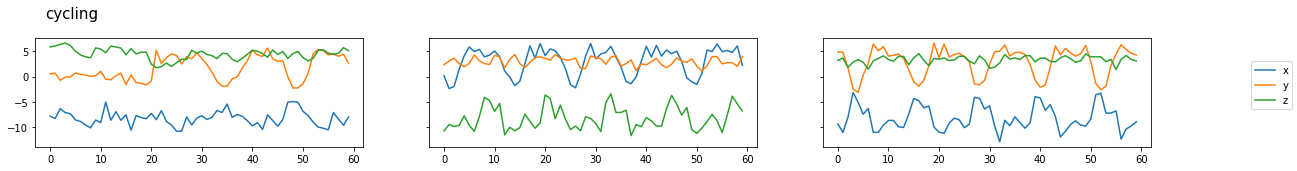

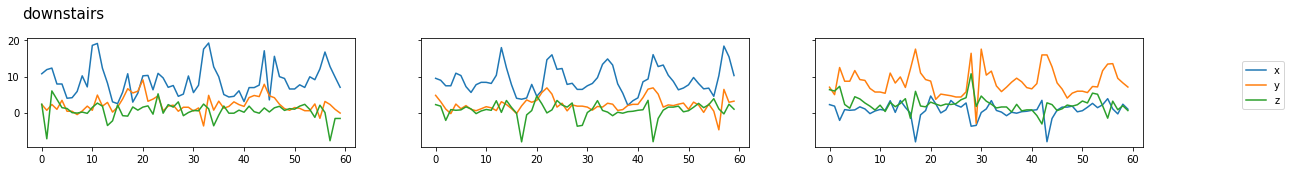

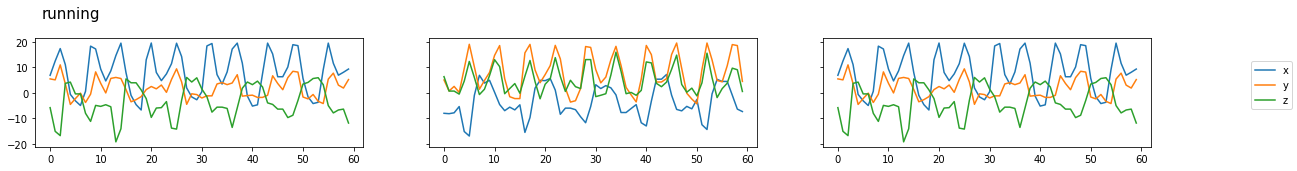

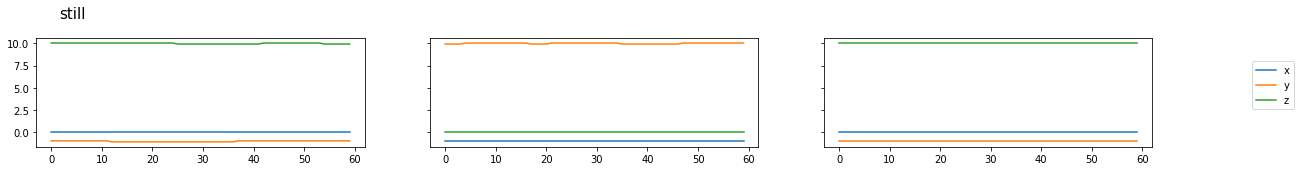

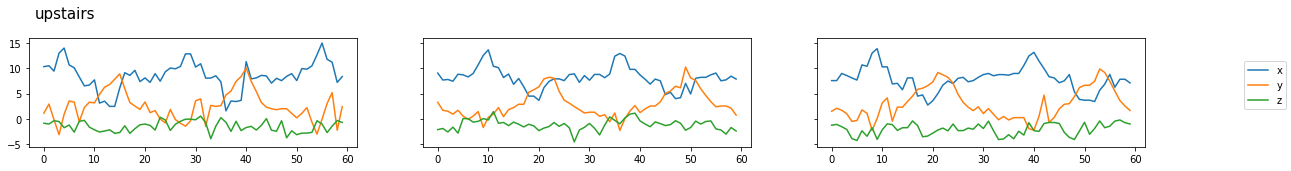

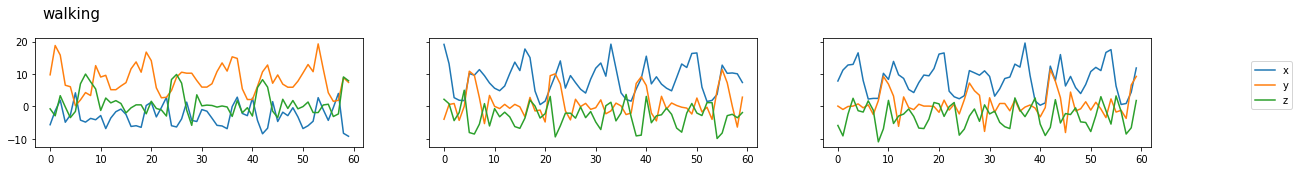

In [10]:
_ = df.groupby(level=0).apply(plot_class_representatives)

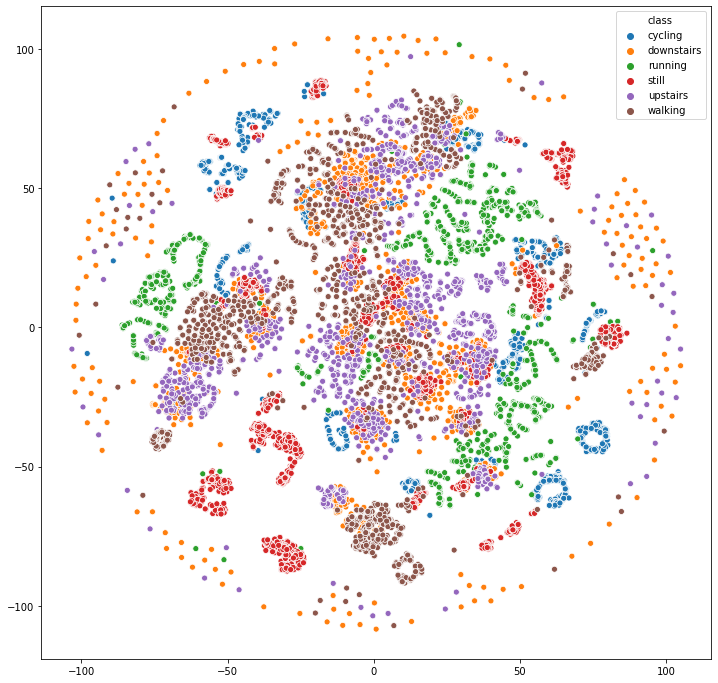

In [11]:
zip_df = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_df[:, 0], y=zip_df[:, 1], hue=df.index.get_level_values('class'))

There is some separation for very different activities, but `downstairs`, `upstairs` and `walking` pretty mixed up. Moreover, result vectors have raw data, which is not so good features for further analysis.

### Statistic features
A very simple way to pick up features is to define what statistical difference (mean, min, max, std, quartiles) is between the classes. Based on that we can make a statistical evaluation of each frame.

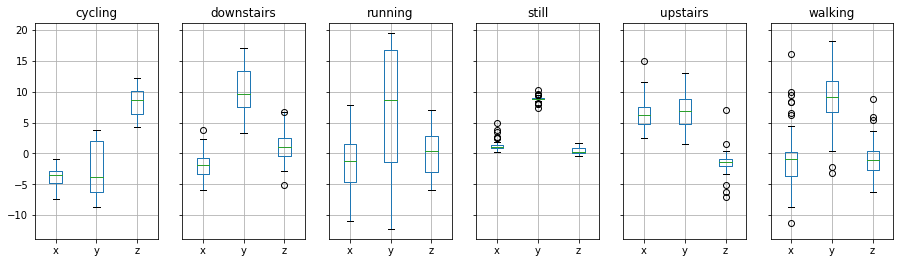

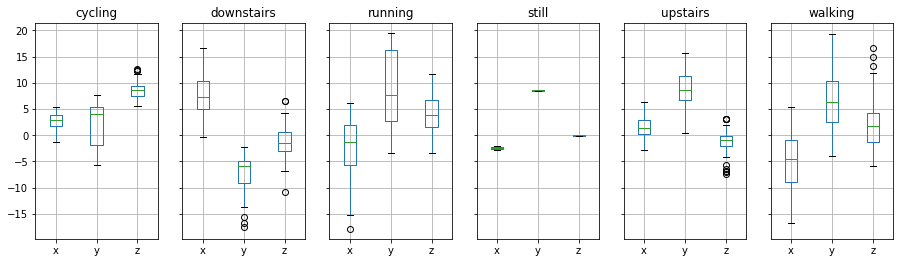

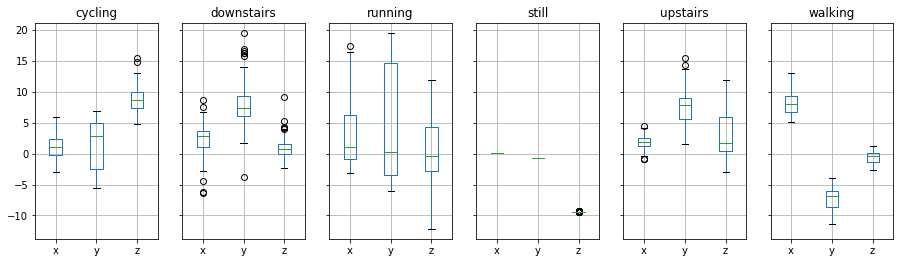

In [12]:
df = feat['orig']

_ = df.groupby(level=0).apply(lambda g: g.iloc[random.randint(0, g.shape[0])]).stack(level=0).T.stack(level=0).groupby(level=1).boxplot(figsize=(20, 4), layout=(1, 8))
_ = df.groupby(level=0).apply(lambda g: g.iloc[random.randint(0, g.shape[0])]).stack(level=0).T.stack(level=0).groupby(level=1).boxplot(figsize=(20, 4), layout=(1, 8))
_ = df.groupby(level=0).apply(lambda g: g.iloc[random.randint(0, g.shape[0])]).stack(level=0).T.stack(level=0).groupby(level=1).boxplot(figsize=(20, 4), layout=(1, 8))

In [13]:
def prepareStatisticFeatures(data):
    return data.stack(level=0).T.apply(lambda s: s.describe().drop('count')).T.unstack(level=2)

In [14]:
df = prepareStatisticFeatures(df)
feat['stat'] = df

In [15]:
df.head()

mean                           std                      \
axis                   x         y         z         x         y         z   
class   sample                                                               
cycling 0      -5.647124 -0.308373  7.385633  2.869463  1.264294  1.552523   
        1      -8.172208  1.613373  4.462792  1.446757  2.376598  1.115490   
        2      -7.844682  2.474008  4.079081  2.732673  3.516715  1.400065   
        3      -8.064310  2.676398  3.409982  2.597897  3.032642  0.868069   
        4      -8.117301  2.855165  3.325706  2.444161  2.835125  0.722831   

                      min                            25%  ...            \
axis                    x         y         z          x  ...         z   
class   sample                                            ...             
cycling 0       -9.232041 -4.711789  5.209783  -7.738060  ...  6.129156   
        1      -10.726024 -2.221819  1.762132  -9.040505  ...  3.687071   
        2      -15.131354 -9.002198  1.187524  -9.567230  ...  3.438074   
        3      -12.947843 -3.715801  1.149217 -10.122684  ...  3.055001   
        4      -12.832921 -3.102885  1.417367  -9.768343  ...  3.007117   

                     50%                           75%                      \
axis                   x         y         z         x         y         z   
class   sample                                                               
cycling 0      -7.201758 -0.172383  6.607996 -3.476381  0.306458  8.829816   
        1      -8.255207  0.804452  4.558560 -7.393295  3.955221  5.181052   
        2      -8.082825  3.869030  4.118027 -5.995081  4.750096  4.683058   
        3      -8.580819  4.079720  3.447650 -5.880159  4.721366  3.830723   
        4      -8.619126  4.060566  3.390190 -6.339846  4.797980  3.907337   

                     max                       
axis                   x         y          z  
class   sample                                 
cycling 0       0.727837  3.217807  11.147403  
        1      -4.903325  5.631162   6.627150  
        2       1.379060  8.619126   9.423577  
        3      -3.217807  6.703764   5.209783  
        4      -3.102885  6.627150   4.520253  

[5 rows x 21 columns]

Sort axis by mean in ascending order

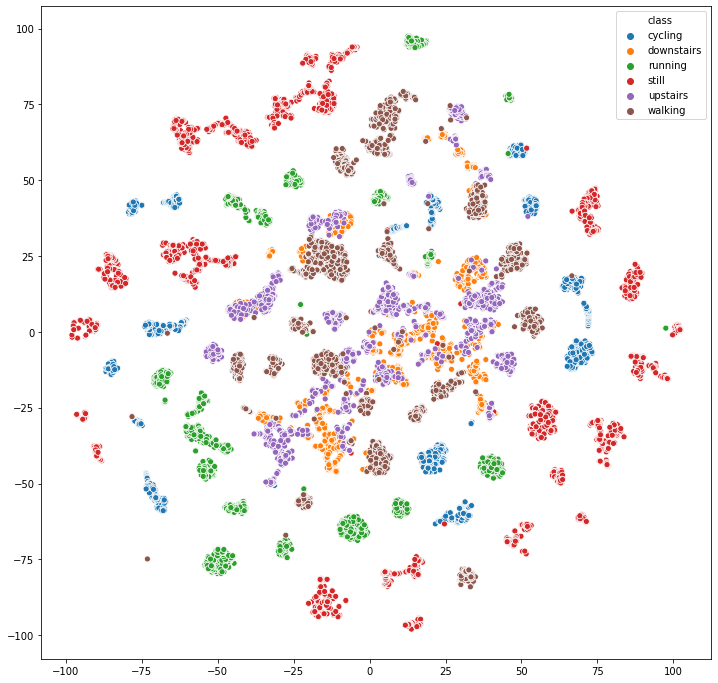

In [16]:
zip_df = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_df[:, 0], y=zip_df[:, 1], hue=df.index.get_level_values('class'))

These statistic feature vectors are shorter and separated the whole dataset into chunks with the same class.

### Signal features
This is one more method to extract useful features from a signal based data.

In [17]:
def prepareSignalFeatures(data):
    data = data.stack(level=0)

    mean = data.mean(axis=1).rename('mean')
    std = data.std(axis=1).rename('std')
    peaks = data.apply(lambda s: signal.find_peaks(s)[0].size, axis=1).rename('peaks')
    
    return pd.concat([mean, std, peaks], axis=1).unstack(level=2)

In [18]:
df = feat['orig']
df = prepareSignalFeatures(df)
feat['signal'] = df

In [19]:
df.head()

mean                           std                      \
axis                   x         y         z         x         y         z   
class   sample                                                               
cycling 0      -5.647124 -0.308373  7.385633  2.869463  1.264294  1.552523   
        1      -8.172208  1.613373  4.462792  1.446757  2.376598  1.115490   
        2      -7.844682  2.474008  4.079081  2.732673  3.516715  1.400065   
        3      -8.064310  2.676398  3.409982  2.597897  3.032642  0.868069   
        4      -8.117301  2.855165  3.325706  2.444161  2.835125  0.722831   

               peaks          
axis               x   y   z  
class   sample                
cycling 0         16  16  17  
        1         17  15  15  
        2         14  11  16  
        3         15  12  16  
        4         15  12  17

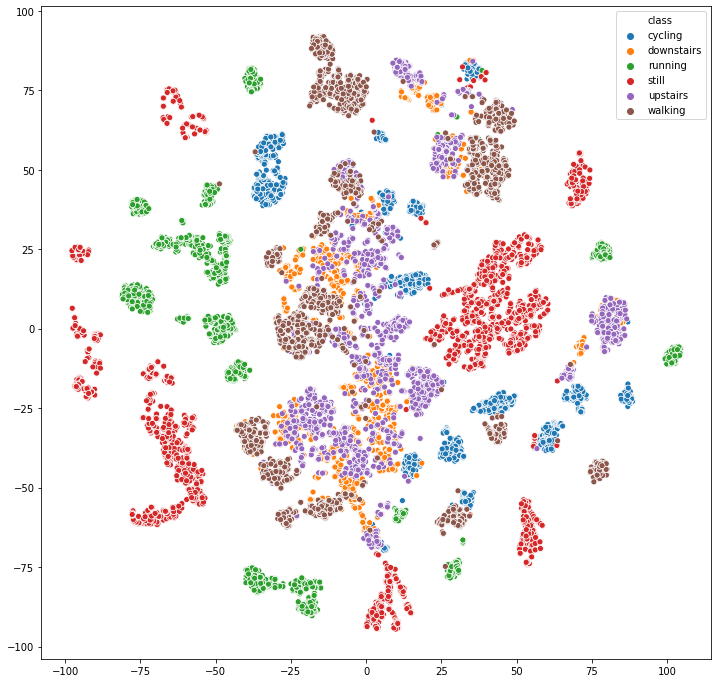

In [20]:
zip_feats = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_feats[:, 0], y=zip_feats[:, 1], hue=df.index.get_level_values('class'))

Previous features look more preferable because of their `walking`, `upstairs` and `downstairs` separabilities. 

### FFT features

The last point is to get FFT sequence from the signals and check them distribution, do we can use them as feature vector.

In [21]:
df = feat['orig']

def prepareHarmonicFeatures(data):
    data = data.stack(level=0)
    data = data.T.apply(
        lambda s: signal.spectrogram(
            s,
            nperseg=s.size,
            window='hann',
            scaling='spectrum',
            mode='magnitude'
        )[2].ravel(), 
    ).T
    
    return data.unstack(level=2).T.swaplevel().sort_index(level=0).T


In [22]:
df = prepareHarmonicFeatures(df)
feat['fft'] = df

In [23]:
df.head()

axis                   x                                                    \
                      0         1         2         3         4         5    
class   sample                                                               
cycling 0       0.891549  1.239201  0.406493  0.143854  0.283538  0.307526   
        1       0.030653  0.163367  0.183211  0.409745  0.568230  0.389793   
        2       0.118951  0.131955  0.072267  0.252959  0.319279  0.966425   
        3       0.018573  0.059538  0.102681  0.092734  0.404520  1.242569   
        4       0.029021  0.023752  0.031726  0.024612  0.642987  1.243138   

axis                                                    ...         z  \
                      6         7         8         9   ...        21   
class   sample                                          ...             
cycling 0       0.454690  0.341764  0.135758  0.122428  ...  0.093853   
        1       0.108406  0.221228  0.228439  0.215856  ...  0.026348   
        2       0.614264  0.376031  0.184680  0.308974  ...  0.169306   
        3       1.169360  0.310452  0.294577  0.393560  ...  0.114564   
        4       0.549398  0.100394  0.054733  0.494753  ...  0.011597   

axis                                                                        \
                      22        23        24        25        26        27   
class   sample                                                               
cycling 0       0.109925  0.119161  0.091550  0.032131  0.018342  0.040354   
        1       0.020260  0.025347  0.047703  0.059201  0.145944  0.069042   
        2       0.327209  0.461382  0.471400  0.330281  0.234933  0.230993   
        3       0.069930  0.113683  0.060110  0.053383  0.071983  0.069584   
        4       0.044404  0.041388  0.053095  0.087921  0.112940  0.061440   

axis                                          
                      28        29        30  
class   sample                                
cycling 0       0.075698  0.038761  0.056237  
        1       0.031958  0.062025  0.111969  
        2       0.246255  0.311092  0.328268  
        3       0.085621  0.094380  0.079763  
        4       0.018721  0.038080  0.058656  

[5 rows x 93 columns]

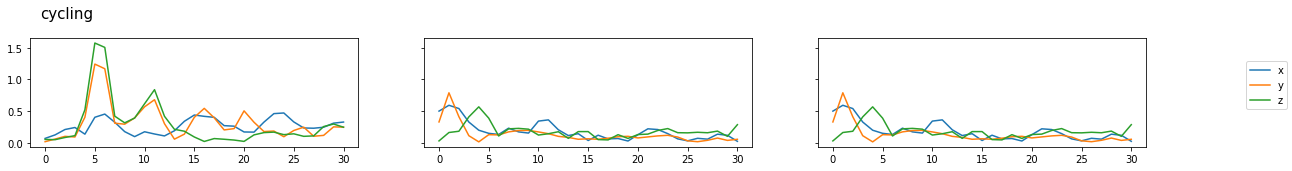

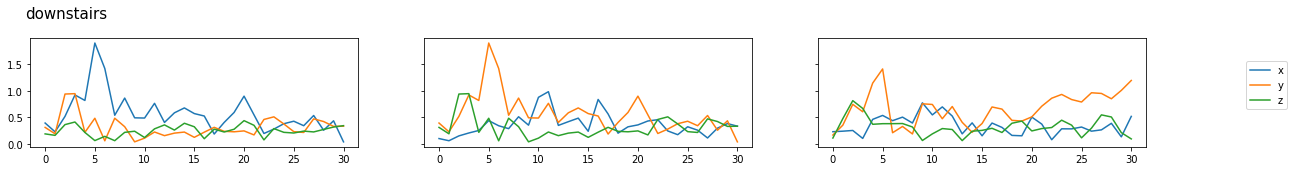

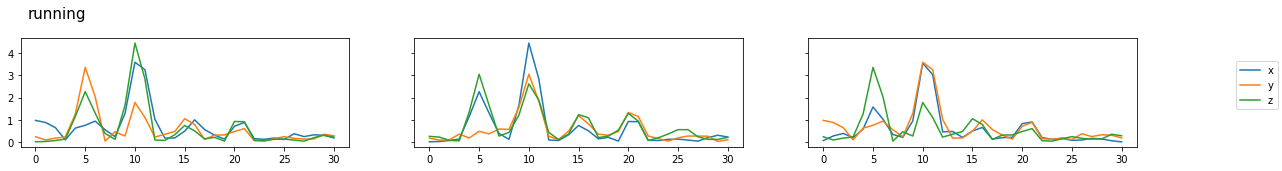

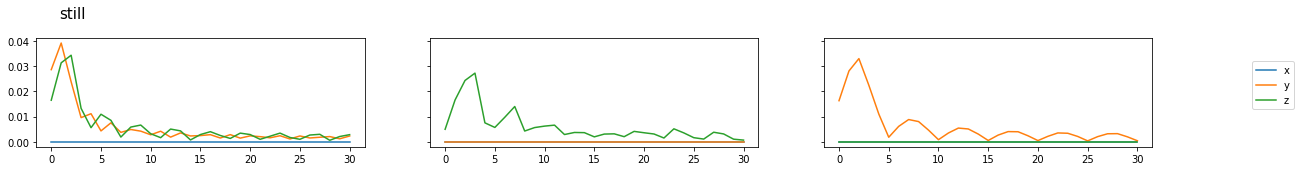

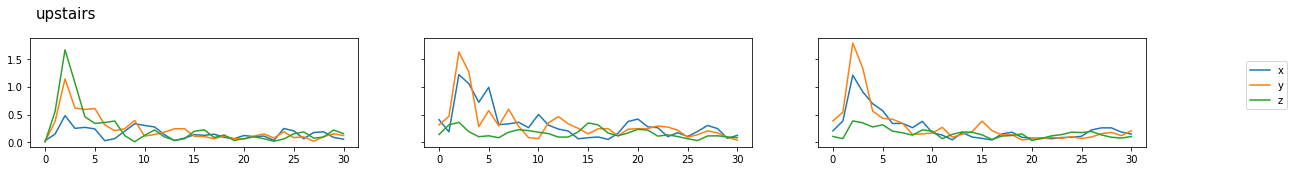

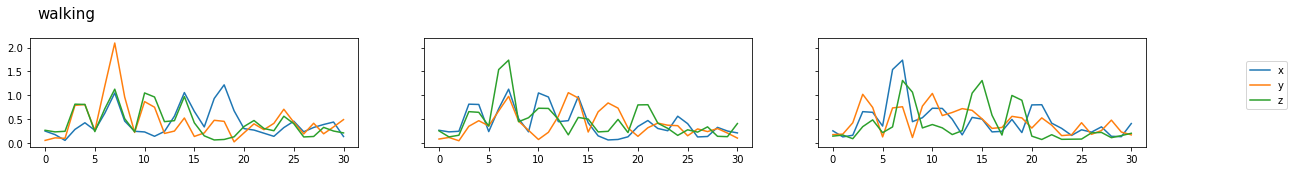

In [24]:
_ = df.groupby(level=0).apply(plot_class_representatives)

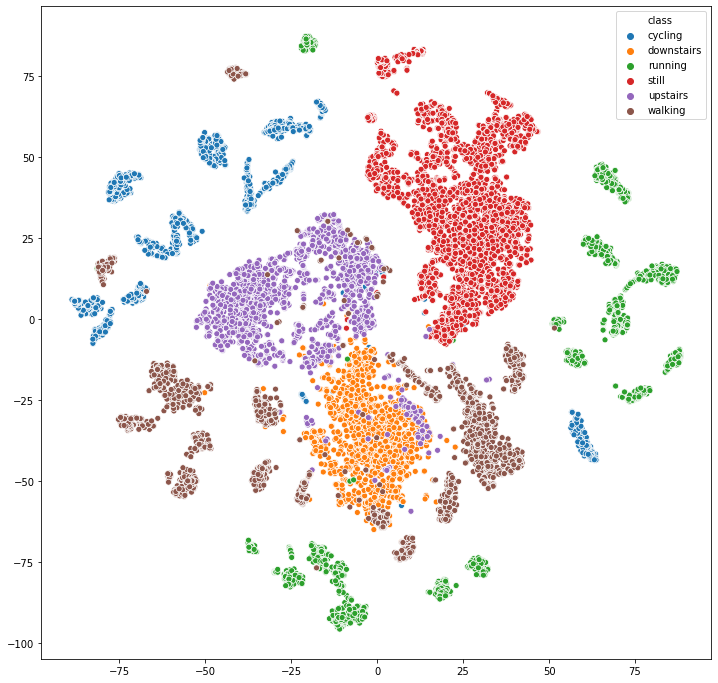

In [25]:
zip_feats = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_feats[:, 0], y=zip_feats[:, 1], hue=df.index.get_level_values('class'))

In [26]:
def prepareStatisticPeaksFeatures(data):
    return pd.merge(
        data.stack(level=0).T.apply(lambda s: s.describe().drop('count')).T,
        data.apply(lambda s: signal.find_peaks(s)[0].size, axis=1).rename('peaks'),
        left_index=True,
        right_index=True
    ).unstack(level=2)
    
def prepareAllFeatures(data):
    return pd.merge(
        prepareStatisticPeaksFeatures(data),
        prepareHarmonicFeatures(data),
        left_index=True,
        right_index=True
    )

feat['statpeak'] = prepareStatisticPeaksFeatures(feat['orig'])
feat['all'] = prepareAllFeatures(feat['orig'])

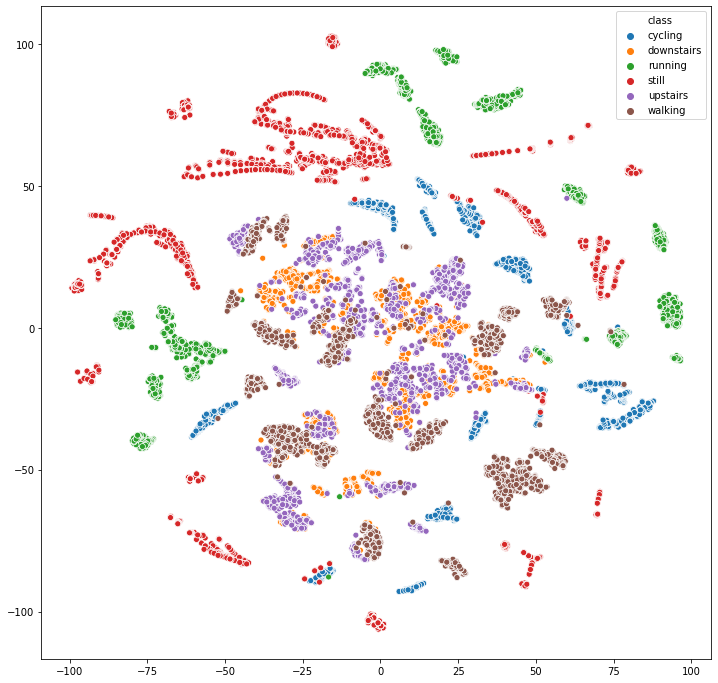

In [27]:
df = feat['statpeak']

zip_feats = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_feats[:, 0], y=zip_feats[:, 1], hue=df.index.get_level_values('class'))

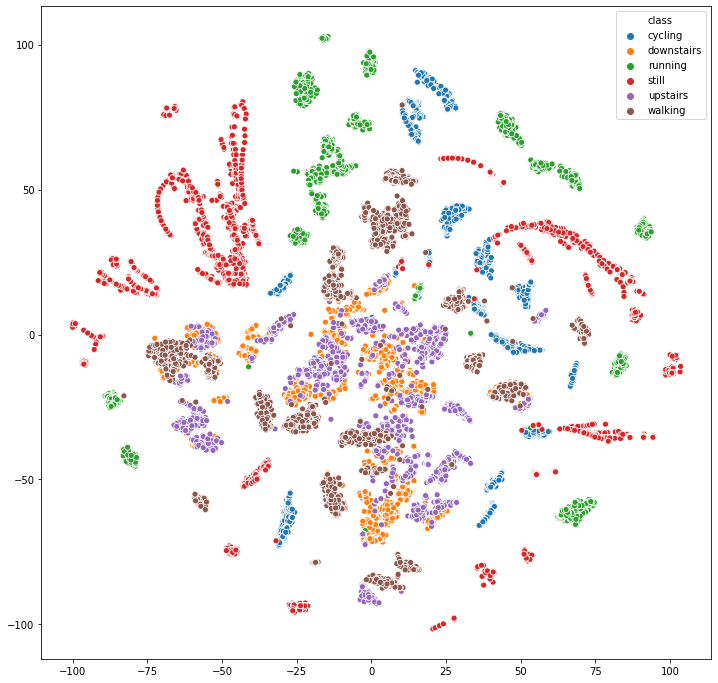

In [28]:
df = feat['all']

zip_feats = TSNE().fit_transform(df)

fig = plt.figure(figsize=(12, 12))
_ = sns.scatterplot(x=zip_feats[:, 0], y=zip_feats[:, 1], hue=df.index.get_level_values('class'))

In [29]:
feat_func = {
    'orig': lambda arg: arg,
    'stat': prepareStatisticFeatures,
    'signal': prepareSignalFeatures,
    'fft': prepareHarmonicFeatures,
    'statpeak': prepareStatisticPeaksFeatures,
    'all': prepareAllFeatures,
}

In [30]:
feat.keys()

dict_keys(['orig', 'stat', 'signal', 'fft', 'statpeak', 'all'])

In [31]:
feat_func.keys()

dict_keys(['orig', 'stat', 'signal', 'fft', 'statpeak', 'all'])

## Train test data split

In [32]:
def frac_tt_split(data, train_frac=0.75, random_state=0):
    train = data.sample(frac=train_frac, random_state=random_state)
    test = data.drop(train.index)
    return train, test

def balanced_test_tt_split(data, n_per_class, random_state=0):
    test = data \
        .groupby(level=0, group_keys=False) \
        .apply(lambda g: g.sample(n=n_per_class, random_state=random_state)) \
        .sort_index()
    train = data.drop(test.index).sample(frac=1, random_state=random_state)
    return train, test

def frac_tt_split_on_experiments(data, experiments, train_frac=0.75, random_state=0):
    data = data.copy()
    data['experiment'] = experiments
    
    train_index = data \
        .groupby(level='class') \
        .apply(lambda g: 
            train_test_split(
                g['experiment'].unique(),
                train_size=train_frac,
                random_state=random_state
            )[0]
        )

    train_index = np.concatenate(train_index.values)

    train = data \
        [data['experiment'].isin(train_index)] \
        .drop(columns='experiment') \
        .sample(frac=1, random_state=random_state)
    
    test = data \
        .drop(train.index) \
        .drop(columns='experiment') \
        .sample(frac=1, random_state=random_state)
    
    return train, test

## Model selection

### KNN

In [33]:
model = {
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [10, 20, 30, 50, 100, 200],
            'weights': ['uniform', 'distance'],
        }
    },
    'LogisticResgression': {
        'estimator': LogisticRegression(),
        'param_grid':{
            'multi_class': ['ovr'],
            'max_iter': [2000],
            'C': [0.01, 0.1, 1, 10, 100], 
            'solver': ['lbfgs'],
        }
    },
    'Support Vector Machine': {
        'estimator': Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())]),
        'param_grid': {
            'svm__decision_function_shape': ['ovo', 'ovr'],
            'svm__C': [0.01, 0.1, 1, 10, 100], 
            'svm__gamma': [0.1, 1, 10],
        }
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200] 
        }
    }
}

In [34]:
feats = {k: v for k, v in feat.items() if k != 'orig'}

In [35]:
feats.keys()

dict_keys(['stat', 'signal', 'fft', 'statpeak', 'all'])

In [36]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

report = {}

for model_name, model_prop in model.items():
    for feat_name, feat_df in feats.items():
        print(f'{model_name} - {feat_name}')

        train_df, test_df = frac_tt_split_on_experiments(feat_df.astype(float), experiment, 0.8, random_state=0)
        # train_df, test_df = frac_tt_split(feat_df.astype(float), 0.8, random_state=0)
        # train_df, test_df = balanced_test_tt_split(feats, 120, random_state=1)
        
        gs = GridSearchCV(model_prop['estimator'], model_prop['param_grid'], cv=2)
        gs = gs.fit(train_df, train_df.index.get_level_values('class'))
        
        report[(model_name, feat_name)] = {
            'gs': gs,
            'data': (train_df, test_df),
            'score': gs.score(test_df, test_df.index.get_level_values('class'))
        }


KNN - stat
KNN - signal
KNN - fft
KNN - statpeak
KNN - all


c:\users\dkibe\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



LogisticResgression - stat
LogisticResgression - signal
LogisticResgression - fft
LogisticResgression - statpeak
LogisticResgression - all


c:\users\dkibe\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Support Vector Machine - stat
Support Vector Machine - signal
Support Vector Machine - fft
Support Vector Machine - statpeak
Support Vector Machine - all


c:\users\dkibe\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Random Forest - stat
Random Forest - signal
Random Forest - fft
Random Forest - statpeak
Random Forest - all


c:\users\dkibe\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



statpeak
stat
statpeak
all
stat
signal
stat
statpeak
signal
stat
statpeak
signal
signal
all
all
all
fft
fft
fft
fft


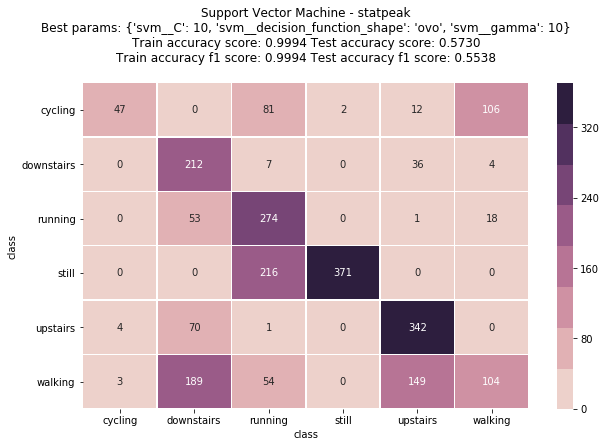

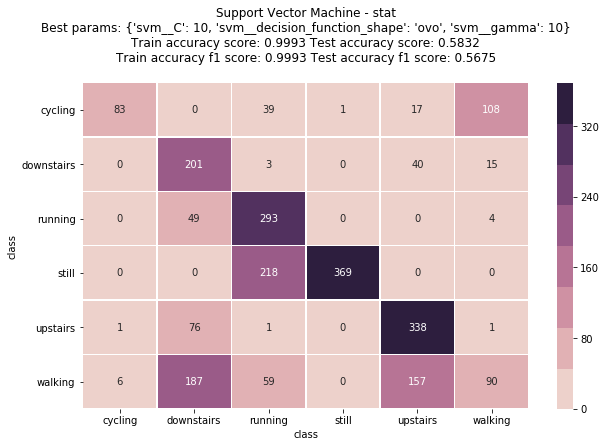

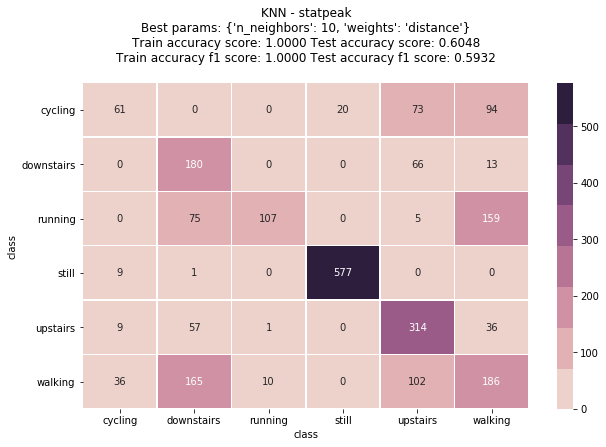

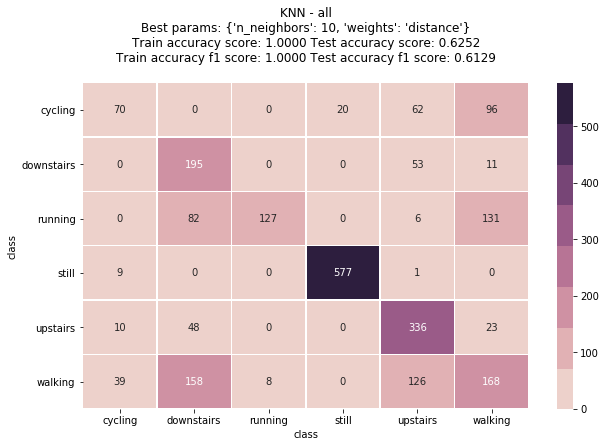

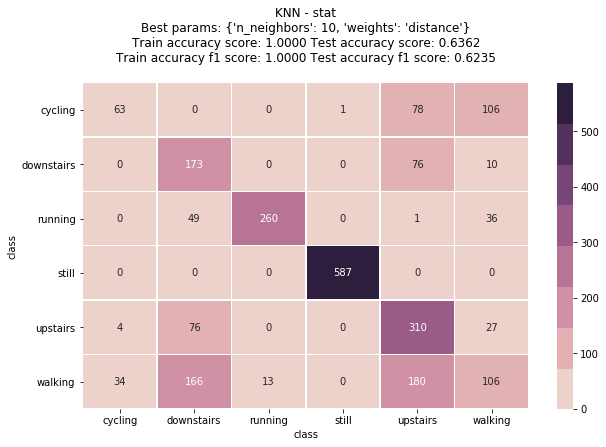

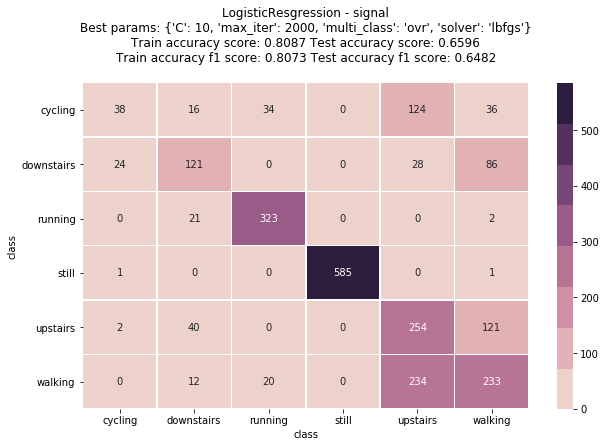

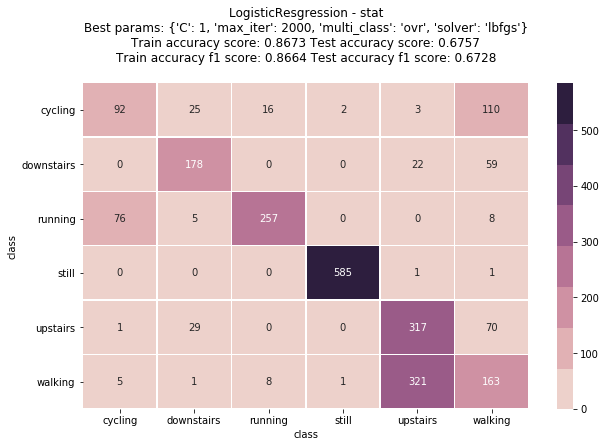

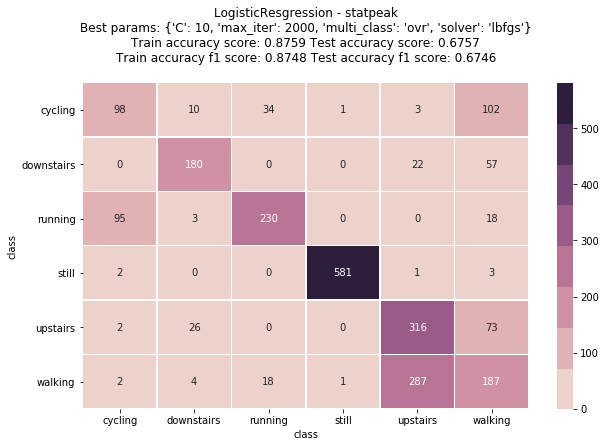

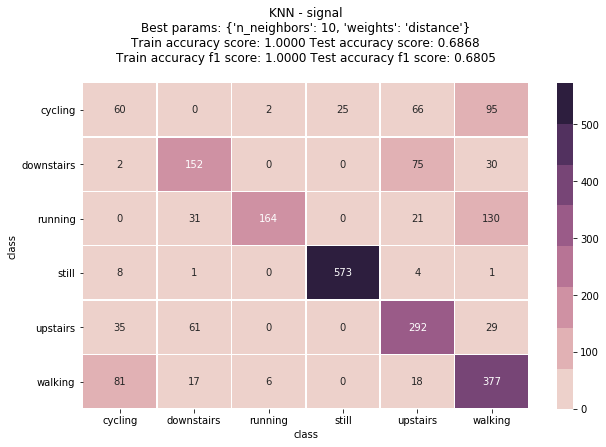

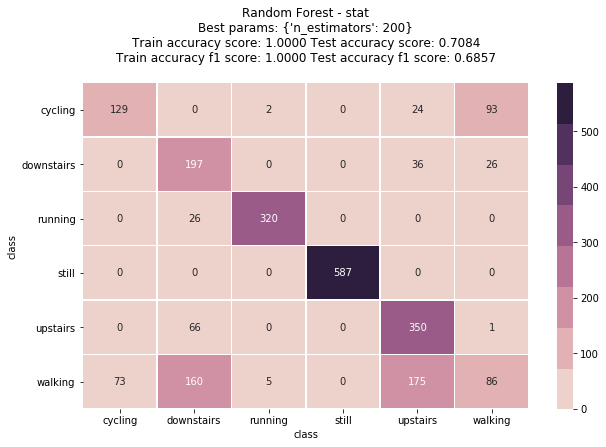

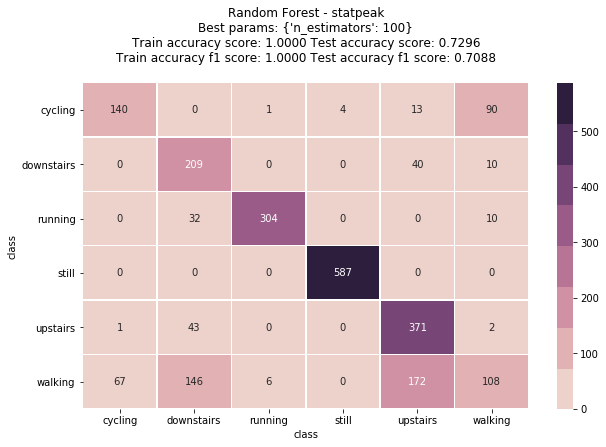

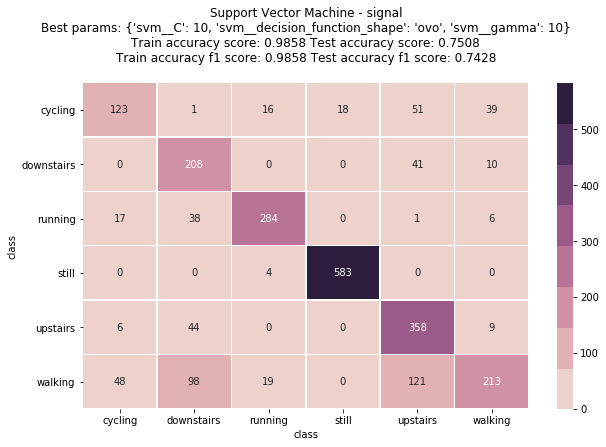

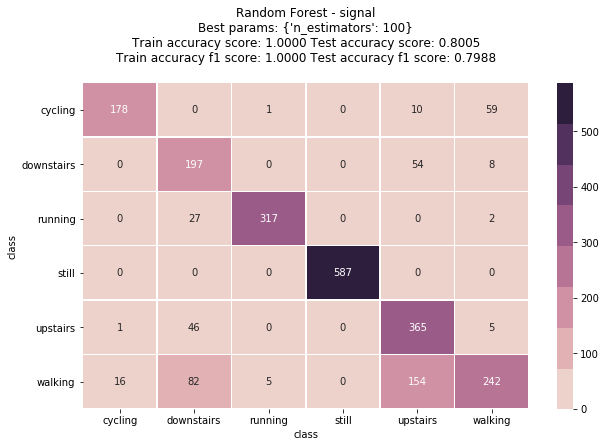

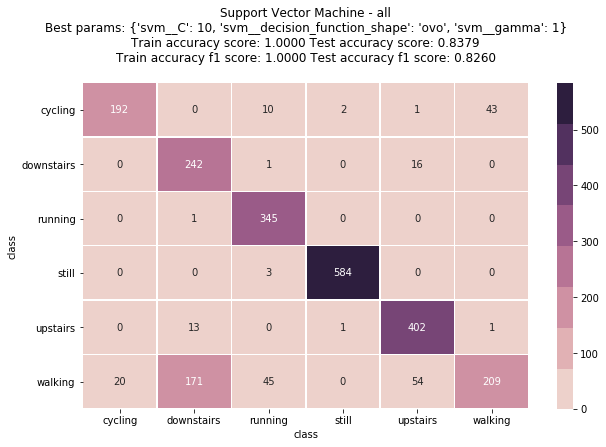

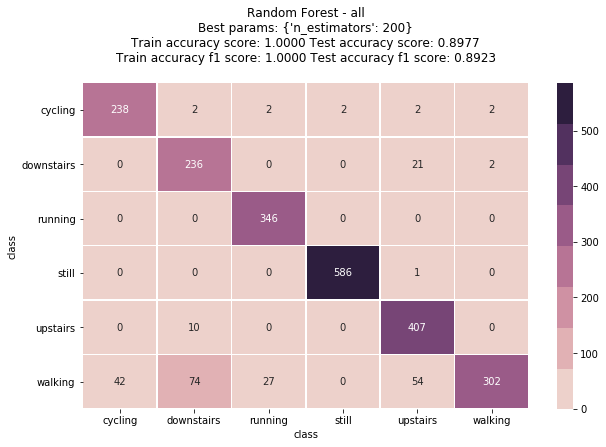

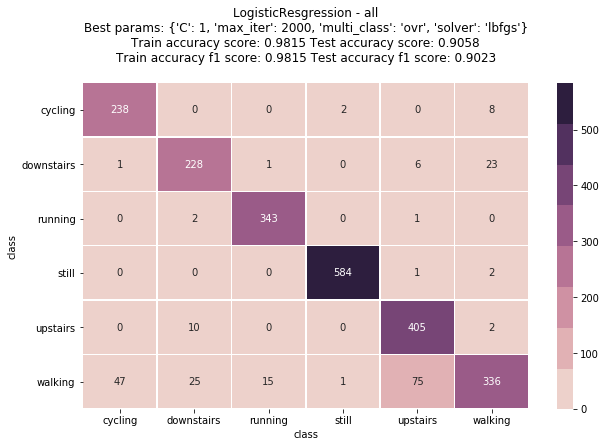

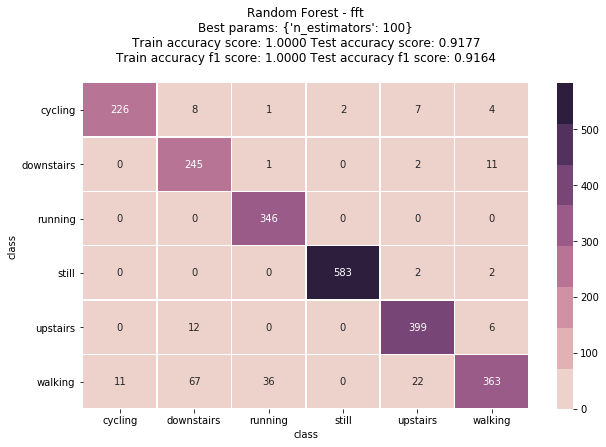

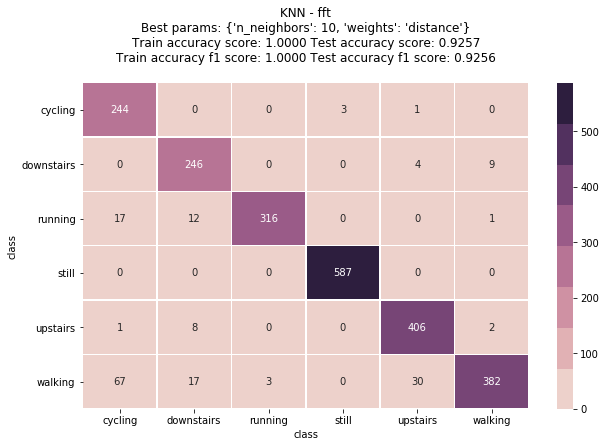

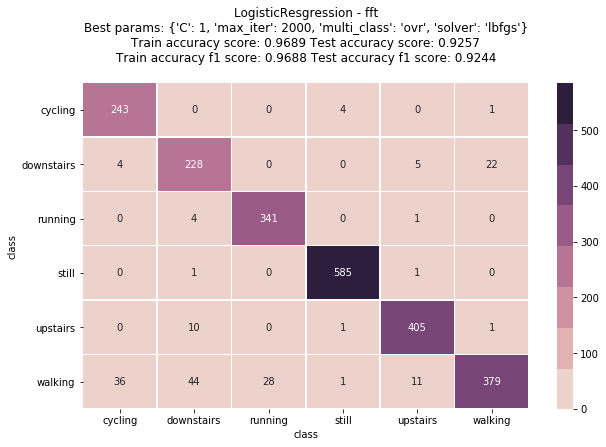

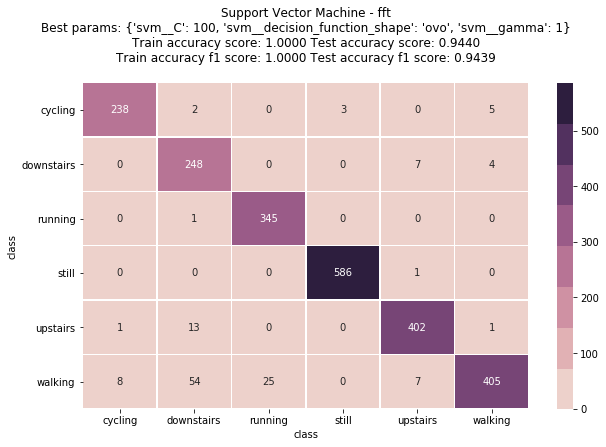

In [37]:
report = dict(sorted(report.items(), key=lambda i: i[1]['score']))

for (model_name, feat_name), info in report.items():
    print(feat_name)
    
    gs = info['gs']
    train_df, _ = info['data']
    test_orig_df = feat['orig'].drop(train_df.index)
    
    pred_train_df = gs.predict(train_df)
    
    start_time = time.time()
    test_df = feat_func[feat_name](test_orig_df)
    pred_test_df = gs.predict(test_df)
    report[(model_name, feat_name)]['time'] = time.time() - start_time
    
    size = sys.getsizeof(pickle.dumps(gs.best_estimator_))
    report[(model_name, feat_name)]['size'] = size
    
    title = f'{model_name} - {feat_name}\n'
    
    title += f'Best params: {gs.best_params_}\n'

    train_acc = gs.score(train_df, train_df.index.get_level_values('class'))
    test_acc = gs.score(test_df, test_df.index.get_level_values('class'))

    title += f'Train accuracy score: {train_acc:.4f} Test accuracy score: {test_acc:.4f}\n'
    
    train_acc = f1_score(train_df.index.get_level_values('class'), pred_train_df, average='weighted')
    test_acc = f1_score(test_df.index.get_level_values('class'), pred_test_df, average='weighted')
    report[(model_name, feat_name)]['f1_score'] = test_acc

    title += f'Train accuracy f1 score: {train_acc:.4f} Test accuracy f1 score: {test_acc:.4f}\n'
    
    cm = confusion_matrix(test_df.index.get_level_values('class'), pred_test_df)
    cm = pd.DataFrame(
        cm,
        index=test_df.index.levels[0],
        columns=test_df.index.levels[0]
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap=sns.cubehelix_palette(8))
    _ = plt.title(title)


In [38]:
results = {k: {kk: vv for kk, vv in v.items() if kk in ['f1_score', 'time', 'size']} for k, v in report.items()}
results = pd.DataFrame(results).T.sort_index()
results.index = results.index.map(' - '.join)
results.head()


f1_score        size       time
KNN - all       0.612872  20223325.0  29.191776
KNN - fft       0.925614  16103777.0   7.193452
KNN - signal    0.680494   1685341.0   0.767029
KNN - stat      0.623525   3745119.0  25.790320
KNN - statpeak  0.593243   4260061.0  27.256800

In [39]:
results = results.sort_values('time', ascending=False)

fig = go.Figure(data=[
    go.Bar(
        y=results.index,
        x=results['time'],
        orientation='h',
        text=(results['time'] * 1000).round(2),
        textposition='outside'
    )
])
fig.update_layout(barmode='group', width=700, height=700, plot_bgcolor='rgba(255,255,255,0)', paper_bgcolor='rgba(255,255,255,0)')
fig.update_xaxes(showticklabels=False, showgrid=False)
fig.show()

In [40]:
results = results.sort_values('size', ascending=False)

fig = go.Figure(data=[
    go.Bar(
        y=results.index,
        x=results['size'],
        orientation='h',
        text=results['size'],
        textposition='outside'
    )
])
fig.update_layout(barmode='group', width=700, height=700, plot_bgcolor='rgba(255,255,255,0)', paper_bgcolor='rgba(255,255,255,0)')
fig.update_xaxes(showticklabels=False, showgrid=False)
fig.show()

In [41]:
results = results.sort_values('f1_score')

fig = go.Figure(data=[
    go.Bar(
        y=results.index, 
        x=results['f1_score'], 
        orientation='h',
        text=(results['f1_score'] * 100).round(2).astype(str),
        textposition='auto'
    )
])
fig.update_layout(barmode='group', width=700, height=700, plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_xaxes(showticklabels=False)
fig.show()

In [124]:
rating = (
    (results['f1_score'] / results['f1_score'].max()) * \
    (1 - results['time'] / results['time'].max()) *  \
    (1 - results['size'] / results['size'].max()) 
).sort_values()

In [125]:
fig = go.Figure(data=[
    go.Bar(
        y=rating.index, 
        x=rating, 
        orientation='h',
        text=(rating * 100).round(2).astype(str),
        textposition='auto'
    )
])
fig.update_layout(barmode='group', width=700, height=700, plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_xaxes(showticklabels=False)
fig.show()